In [1]:
# load checkpoints/gmf.pt

import torch
checkpoint = torch.load("checkpoints/gmf_refined_best.pt")
print("Checkpoint loaded successfully.")
print(f"Number of Gaussians in checkpoint: {checkpoint['means'].shape[0]}")

Checkpoint loaded successfully.
Number of Gaussians in checkpoint: 12145


In [8]:
# Initialize the model with the same architecture
import os
import sys
from pathlib import Path

project_src = Path('/workspace/HiSNeGS/src').resolve()
os.chdir(project_src)

# Ensure local project wins over any stale external path (e.g., /workspace/neurogs/...)
sys.path = [p for p in sys.path if 'neurogs_v7' not in p and '/workspace/neurogs' not in p]
if str(project_src) not in sys.path:
    sys.path.insert(0, str(project_src))

# Import torch first so extension deps are loaded from the active env
import torch
from model import GaussianMixtureField
import yaml

# Load config to get model parameters
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

# Create model with same architecture - get K from checkpoint
num_gaussians = checkpoint['means'].shape[0]
print(f"Number of Gaussians: {num_gaussians}")

field = GaussianMixtureField(
    num_gaussians=num_gaussians,
    init_scale=config['model']['init_scale'],
    bounds=config['model']['bounds']

)

# Load trained parameters - checkpoint is the state_dict directly
field.load_state_dict(checkpoint)
field.eval()
field = field.cuda()
print("Model loaded and ready for rendering")

Number of Gaussians: 12145
Model loaded and ready for rendering


In [9]:
# Reconstruct volume by evaluating field on a dense 3D grid
import torch
import numpy as np
from tqdm import tqdm

# Clamp amplitudes before inference (same as training does each step)
if hasattr(field, 'clamp_log_amplitudes_'):
    # Prefer configured bounds if present; otherwise use safe defaults.
    # These defaults match common training-time clamps for this model family.
    lo = config.get('model', {}).get('log_amplitude_lo', -7.6)
    hi = config.get('model', {}).get('log_amplitude_hi', 2.0)
    field.clamp_log_amplitudes_(lo, hi)

print("Reconstructing volume...")

# Grid resolution (use same as original data)
Z, Y, X = 100, 647, 813  # From the training log

# Create 3D grid in normalized coordinates [-1, 1]
z_coords = torch.linspace(-1, 1, Z, device='cuda')
y_coords = torch.linspace(-1, 1, Y, device='cuda')
x_coords = torch.linspace(-1, 1, X, device='cuda')

# Reconstruct volume in chunks to avoid OOM
chunk_size = 2048  # Process this many points at a time
reconstructed_volume = np.zeros((Z, Y, X), dtype=np.float32)

with torch.no_grad():
    for iz in tqdm(range(Z), desc="Rendering slices"):
        # Create 2D grid for this z-slice
        yy, xx = torch.meshgrid(y_coords, x_coords, indexing='ij')
        zz = torch.full_like(yy, z_coords[iz])
        
        # Stack into (Y*X, 3) points in (x, y, z) order
        points = torch.stack([xx.flatten(), yy.flatten(), zz.flatten()], dim=1)
        
        # Evaluate in chunks
        slice_values = []
        for i in range(0, points.shape[0], chunk_size):
            chunk = points[i:i+chunk_size]
            vals = field(chunk)
            slice_values.append(vals.cpu())
        
        # Combine and reshape
        slice_values = torch.cat(slice_values, dim=0)
        reconstructed_volume[iz] = slice_values.reshape(Y, X).numpy()

# Clamp to training range [0, 1]
reconstructed_volume = np.clip(reconstructed_volume, 0.0, 1.0)

print(f"Volume reconstructed: shape {reconstructed_volume.shape}")
print(f"Value range: [{reconstructed_volume.min():.4f}, {reconstructed_volume.max():.4f}]")

Reconstructing volume...


Rendering slices:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Using CUDA kernel: N=2048, K=12145, mem_estimate=1.19GB


Rendering slices: 100%|██████████| 100/100 [00:32<00:00,  3.09it/s]

Volume reconstructed: shape (100, 647, 813)
Value range: [0.0392, 1.0000]


MIP shape: (647, 813)


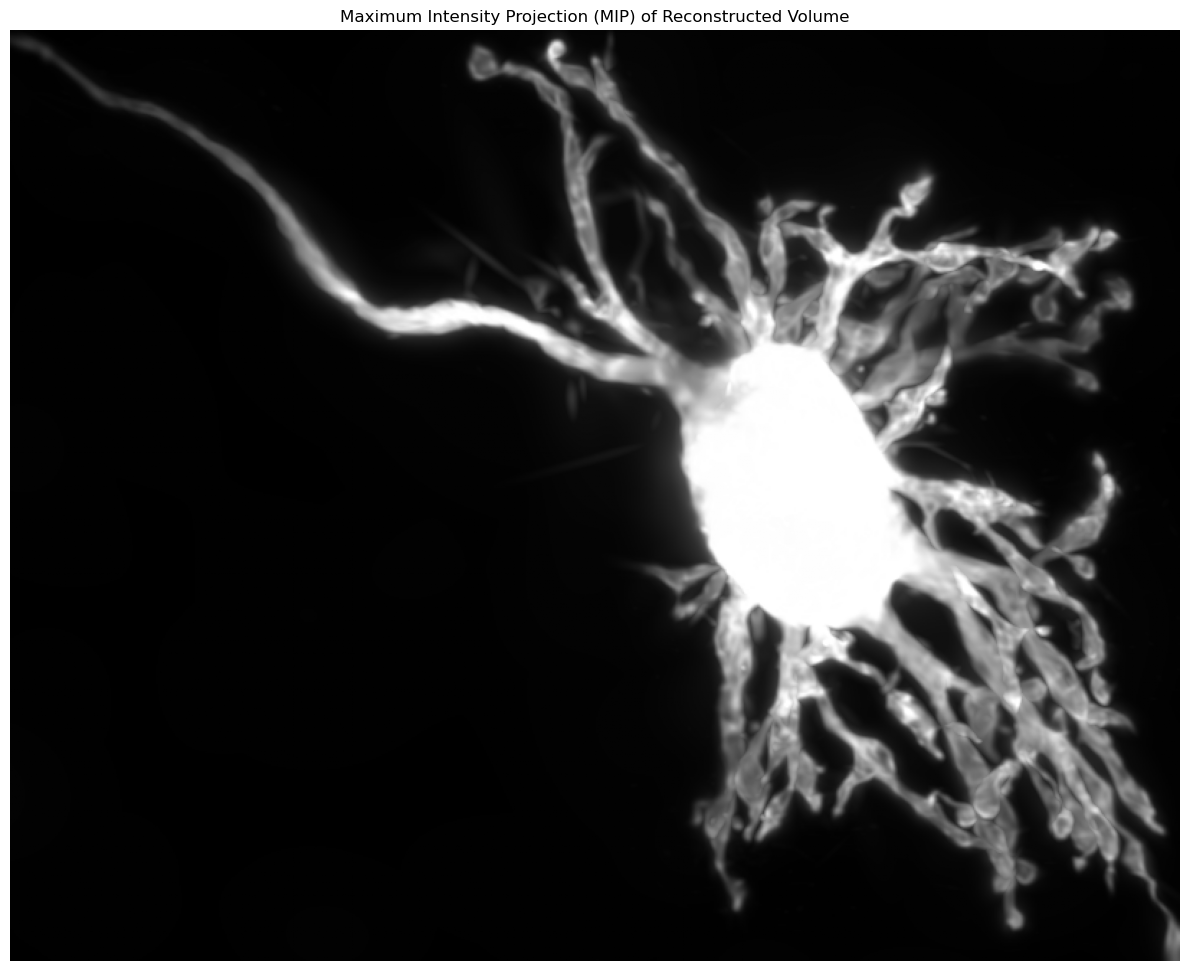

MIP saved to reconstructed_mip.png


In [10]:
# Compute and display MIP
import matplotlib.pyplot as plt

def render_mip(volume):
    """Compute maximum intensity projection along z-axis"""
    mip = np.max(volume, axis=0)
    # Normalize to [0, 255] for visualization
    if mip.max() > mip.min():
        mip_normalized = (mip - mip.min()) / (mip.max() - mip.min()) * 255
    else:
        mip_normalized = np.zeros_like(mip)
    return mip_normalized.astype(np.uint8)

mip_image = render_mip(reconstructed_volume)
print(f"MIP shape: {mip_image.shape}")

# Display
plt.figure(figsize=(12, 10))
plt.imshow(mip_image, cmap='gray')
plt.title('Maximum Intensity Projection (MIP) of Reconstructed Volume')
plt.axis('off')
plt.tight_layout()
plt.savefig('reconstructed_mip.png', dpi=150, bbox_inches='tight')
plt.show()

print("MIP saved to reconstructed_mip.png")

Ground truth volume shape: (100, 647, 813)
Ground truth MIP shape: (647, 813)

RECONSTRUCTION METRICS
PSNR: 35.27 dB
SSIM: 0.9557


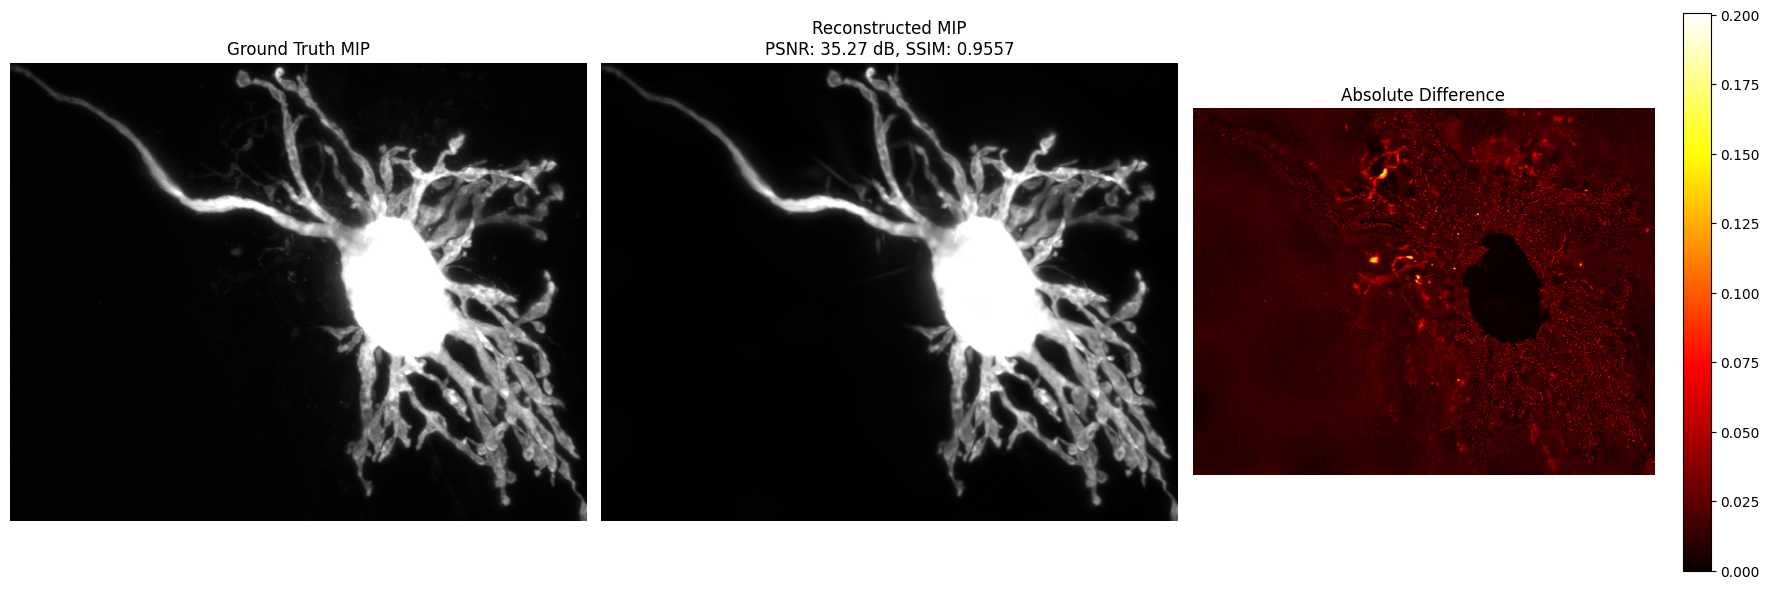

Comparison saved to mip_comparison.png


In [82]:
# Load ground truth volume and compute metrics
import tifffile as tiff
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from neurogs_v7 import load_tif_data

# Load ground truth volume (normalized to [0, 1], same as training)
gt_volume = load_tif_data(config['data']['tif_path'])
print(f"Ground truth volume shape: {gt_volume.shape}")

# Compute ground truth MIP
gt_mip = np.max(gt_volume, axis=0)
print(f"Ground truth MIP shape: {gt_mip.shape}")

# Get reconstructed MIP in [0, 1] range (before the uint8 conversion)
recon_mip = np.max(reconstructed_volume, axis=0)

# Match the training range: clamp reconstruction to [0, 1] instead of rescaling
recon_mip_clipped = np.clip(recon_mip, 0.0, 1.0)

# Calculate PSNR and SSIM
psnr_value = psnr(gt_mip, recon_mip_clipped, data_range=1.0)
ssim_value = ssim(gt_mip, recon_mip_clipped, data_range=1.0)

print("\n" + "="*60)
print("RECONSTRUCTION METRICS")
print("="*60)
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print("="*60)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(gt_mip, cmap='gray')
axes[0].set_title('Ground Truth MIP')
axes[0].axis('off')

axes[1].imshow(recon_mip_clipped, cmap='gray')
axes[1].set_title(f'Reconstructed MIP\nPSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.4f}')
axes[1].axis('off')

# Difference map
diff = np.abs(gt_mip - recon_mip_clipped)
im = axes[2].imshow(diff, cmap='hot')
axes[2].set_title('Absolute Difference')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.savefig('mip_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison saved to mip_comparison.png")

In [77]:
# 3D Volumetric PSNR (matches training metric exactly)
import math

# Compute voxel-wise MSE on full 3D volume (same as training evaluation)
recon_clipped = np.clip(reconstructed_volume, 0.0, 1.0)
mse_3d = np.mean((gt_volume - recon_clipped) ** 2)
mae_3d = np.mean(np.abs(gt_volume - recon_clipped))
psnr_3d = -10 * math.log10(max(mse_3d, 1e-12))

print("="*60)
print("3D VOLUMETRIC METRICS (matches training log)")
print("="*60)
print(f"PSNR (3D): {psnr_3d:.2f} dB")
print(f"MSE  (3D): {mse_3d:.6f}")
print(f"MAE  (3D): {mae_3d:.6f}")
print("="*60)
print(f"\nMIP PSNR:  {psnr_value:.2f} dB  (2D projection metric)")
print(f"3D PSNR:   {psnr_3d:.2f} dB  (voxel-wise, same as training)")

3D VOLUMETRIC METRICS (matches training log)
PSNR (3D): 39.34 dB
MSE  (3D): 0.000117
MAE  (3D): 0.008010

MIP PSNR:  35.32 dB  (2D projection metric)
3D PSNR:   39.34 dB  (voxel-wise, same as training)


In [83]:
# Compression metrics: DPV (Data Per Voxel) and Compression Rate

# Original volume size
num_voxels = gt_volume.size  # Z * Y * X
original_bytes = num_voxels * 4  # float32 = 4 bytes per voxel

# Model parameters: each Gaussian has means(3) + log_scales(3) + quaternions(4) + log_amplitudes(1) = 11 params
params_per_gaussian = 3 + 3 + 4 + 1  # 11
total_params = num_gaussians * params_per_gaussian
model_bytes = total_params * 4  # float32 = 4 bytes per param

# DPV: data (parameters) per voxel — how many model parameters per voxel
dpv = total_params / num_voxels

# Bits per voxel (BPV) — common in compression literature
bpv = (model_bytes * 8) / num_voxels

# Compression rate = original size / model size
compression_rate = original_bytes / model_bytes

print("="*60)
print("COMPRESSION METRICS")
print("="*60)
print(f"Volume voxels:       {num_voxels:,} ({gt_volume.shape})")
print(f"Original size:       {original_bytes / 1e6:.2f} MB (float32)")
print(f"")
print(f"Gaussians:           {num_gaussians:,}")
print(f"Params/Gaussian:     {params_per_gaussian}")
print(f"Total parameters:    {total_params:,}")
print(f"Model size:          {model_bytes / 1e6:.4f} MB (float32)")
print(f"")
print(f"DPV (params/voxel):  {dpv:.6f}")
print(f"BPV (bits/voxel):    {bpv:.4f}")
print(f"Compression rate:    {compression_rate:.1f}×")
print("="*60)

COMPRESSION METRICS
Volume voxels:       52,601,100 ((100, 647, 813))
Original size:       210.40 MB (float32)

Gaussians:           12,145
Params/Gaussian:     11
Total parameters:    133,595
Model size:          0.5344 MB (float32)

DPV (params/voxel):  0.002540
BPV (bits/voxel):    0.0813
Compression rate:    393.7×


## Siren

In [31]:
# ===================================================================
# SIREN Baseline — same BPV as Gaussian model for fair comparison
# ===================================================================
# Standard SIREN: Linear(3→W) first layer, Linear(W→W) hidden, Linear(W→1) final
# ===================================================================
import torch
import torch.nn as nn
import numpy as np
import math

class SineLayer(nn.Module):
    """Standard sinusoidal activation layer with configurable in/out features."""
    def __init__(self, in_features, out_features, omega_0=30.0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features)
        with torch.no_grad():
            if is_first:
                self.linear.weight.uniform_(-1.0 / in_features, 1.0 / in_features)
            else:
                self.linear.weight.uniform_(
                    -math.sqrt(6.0 / in_features) / omega_0,
                     math.sqrt(6.0 / in_features) / omega_0
                )
    
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))


class SIREN(nn.Module):
    """Standard SIREN: 3→W → W→W × (L-1) → W→1."""
    def __init__(self, in_features=3, out_features=1, hidden_features=256,
                 hidden_layers=4, omega_0=30.0, omega_hidden=30.0):
        super().__init__()
        layers = []
        # First layer: in_features → W
        layers.append(SineLayer(in_features, hidden_features,
                                omega_0=omega_0, is_first=True))
        # Hidden layers: W → W
        for _ in range(hidden_layers - 1):
            layers.append(SineLayer(hidden_features, hidden_features,
                                    omega_0=omega_hidden))
        self.net = nn.Sequential(*layers)
        
        # Final linear layer: W → out
        self.final = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            self.final.weight.uniform_(
                -math.sqrt(6.0 / hidden_features) / omega_hidden,
                 math.sqrt(6.0 / hidden_features) / omega_hidden
            )
    
    def forward(self, x):
        return self.final(self.net(x)).squeeze(-1)

# --- Find architecture that matches target param count ---
target_params = num_gaussians * 11  # 108,977

# Standard SIREN param count (L = total SineLayers including first):
#   First SineLayer (3→W): 3W + W = 4W
#   (L-1) hidden SineLayers (W→W): (L-1)*(W²+W)
#   Final Linear (W→1): W + 1
#   Total = (L-1)*W² + (L+3)*W + 1   (with in_features=3)
L = 4
# Solve: 3W² + 7W + 1 = target_params  →  3W² + 7W + (1-target) = 0
a_coeff, b_coeff, c_coeff = L - 1, L + 3, 1 - target_params
W = int((-b_coeff + math.sqrt(b_coeff**2 - 4 * a_coeff * c_coeff)) / (2 * a_coeff))

def count_params(w, l=L):
    return (l - 1) * w * w + (l + 3) * w + 1

best_W, best_diff = W, abs(target_params - count_params(W))
for w in [W-2, W-1, W, W+1, W+2]:
    if w < 1:
        continue
    if abs(count_params(w) - target_params) < best_diff:
        best_W, best_diff = w, abs(count_params(w) - target_params)
W = best_W

siren = SIREN(in_features=3, out_features=1, hidden_features=W, hidden_layers=L)
siren_params = sum(p.numel() for p in siren.parameters())
siren_bpv = (siren_params * 32) / num_voxels

print(f"SIREN architecture: 3→{W} → {W}→{W} × {L-1} → {W}→1")
print(f"SIREN parameters:   {siren_params:,}")
print(f"Target parameters:  {target_params:,}")
print(f"SIREN BPV:          {siren_bpv:.4f} (target: {bpv:.4f})")
print(f"Param difference:   {siren_params - target_params:+d}")

SIREN architecture: 3→189 → 189→189 × 3 → 189→1
SIREN parameters:   108,676
Target parameters:  108,977
SIREN BPV:          0.0661 (target: 0.0663)
Param difference:   -301


In [32]:
# ===================================================================
# Train SIREN on the same volume
# ===================================================================
import os
from neurogs_v7 import load_tif_data
from tqdm import tqdm

# Load volume (already in memory as gt_volume, but reuse for clarity)
vol_gpu = torch.from_numpy(gt_volume).float().cuda()
Z_vol, Y_vol, X_vol = vol_gpu.shape

siren_ckpt_dir = 'checkpoints/siren_sckpt'
os.makedirs(siren_ckpt_dir, exist_ok=True)

siren = siren.cuda()
siren.train()

optimizer = torch.optim.Adam(siren.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100_000, eta_min=1e-6)

steps = 100_000
batch_size = 8192
best_loss = float('inf')

# Early stopping config
patience = 20          # stop after 20 evals with no PSNR improvement
eval_interval = 500
best_psnr = -float('inf')
no_improve_count = 0

print(f"Training SIREN for up to {steps} steps (early stopping: patience={patience} × {eval_interval} steps)")
print(f"Volume shape: {vol_gpu.shape}")
print(f"Checkpoints → {siren_ckpt_dir}/")

pbar = tqdm(range(steps), desc="SIREN Training")
for step in pbar:
    idx = torch.randint(0, vol_gpu.numel(), (batch_size,), device='cuda')
    
    iz = idx // (Y_vol * X_vol)
    iy = (idx % (Y_vol * X_vol)) // X_vol
    ix = idx % X_vol
    
    xn = (ix.float() / max(X_vol - 1, 1)) * 2 - 1
    yn = (iy.float() / max(Y_vol - 1, 1)) * 2 - 1
    zn = (iz.float() / max(Z_vol - 1, 1)) * 2 - 1
    
    coords = torch.stack([xn, yn, zn], dim=1)
    gt_vals = vol_gpu[iz, iy, ix]
    
    pred = siren(coords)
    loss = torch.nn.functional.mse_loss(pred, gt_vals)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
    
    if (step + 1) % eval_interval == 0:
        with torch.no_grad():
            eval_n = min(100_000, vol_gpu.numel())
            eval_idx = torch.randint(0, vol_gpu.numel(), (eval_n,), device='cuda')
            ez = eval_idx // (Y_vol * X_vol)
            ey = (eval_idx % (Y_vol * X_vol)) // X_vol
            ex = eval_idx % X_vol
            exn = (ex.float() / max(X_vol - 1, 1)) * 2 - 1
            eyn = (ey.float() / max(Y_vol - 1, 1)) * 2 - 1
            ezn = (ez.float() / max(Z_vol - 1, 1)) * 2 - 1
            eval_pts = torch.stack([exn, eyn, ezn], dim=1)
            eval_gt = vol_gpu[ez, ey, ex]
            eval_pred = []
            for ci in range(0, eval_n, 16384):
                eval_pred.append(siren(eval_pts[ci:ci+16384]))
            eval_pred = torch.cat(eval_pred)
            mse_eval = torch.nn.functional.mse_loss(eval_pred, eval_gt).item()
            psnr_eval = -10 * math.log10(max(mse_eval, 1e-12))
        pbar.set_postfix({"loss": f"{loss.item():.6f}", "PSNR": f"{psnr_eval:.2f}", "best": f"{best_psnr:.2f}"})
        
        # Early stopping check
        if psnr_eval > best_psnr + 0.01:  # require at least 0.01 dB improvement
            best_psnr = psnr_eval
            no_improve_count = 0
            torch.save(siren.state_dict(), f'{siren_ckpt_dir}/siren_best.pt')
        else:
            no_improve_count += 1
        
        if no_improve_count >= patience:
            print(f"\nEarly stopping at step {step+1} (best PSNR: {best_psnr:.2f} dB)")
            break
    
    # Save checkpoint every 2000 steps
    if (step + 1) % 2000 == 0:
        torch.save(siren.state_dict(), f'{siren_ckpt_dir}/siren_step{step+1}.pt')

# Load best checkpoint
siren.load_state_dict(torch.load(f'{siren_ckpt_dir}/siren_best.pt'))
torch.save(siren.state_dict(), f'{siren_ckpt_dir}/siren_final.pt')
print(f"\nTraining complete at step {step+1}. Best PSNR: {best_psnr:.2f} dB, Best loss: {best_loss:.6f}")
print(f"Checkpoints saved to {siren_ckpt_dir}/")

Training SIREN for up to 100000 steps (early stopping: patience=20 × 500 steps)
Volume shape: torch.Size([100, 647, 813])
Checkpoints → checkpoints/siren_sckpt/


SIREN Training:   0%|          | 0/100000 [00:00<?, ?it/s]

SIREN Training: 100%|██████████| 100000/100000 [06:03<00:00, 274.92it/s, loss=0.000118, PSNR=39.51, best=39.62]


Training complete at step 100000. Best PSNR: 39.62 dB, Best loss: 0.000097
Checkpoints saved to checkpoints/siren_sckpt/


Reconstructing SIREN volume...


SIREN slices:   2%|▏         | 2/100 [00:00<00:06, 16.28it/s]

SIREN slices: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]



SIREN vs GAUSSIAN — SAME BPV COMPARISON
Metric                   Gaussian        SIREN
------------------------------------------------------------
BPV                        0.0663       0.0661
Parameters                108,977      108,676
3D PSNR (dB)                39.14        39.54
MIP PSNR (dB)               34.02        34.60
MIP SSIM                   0.9458       0.9518


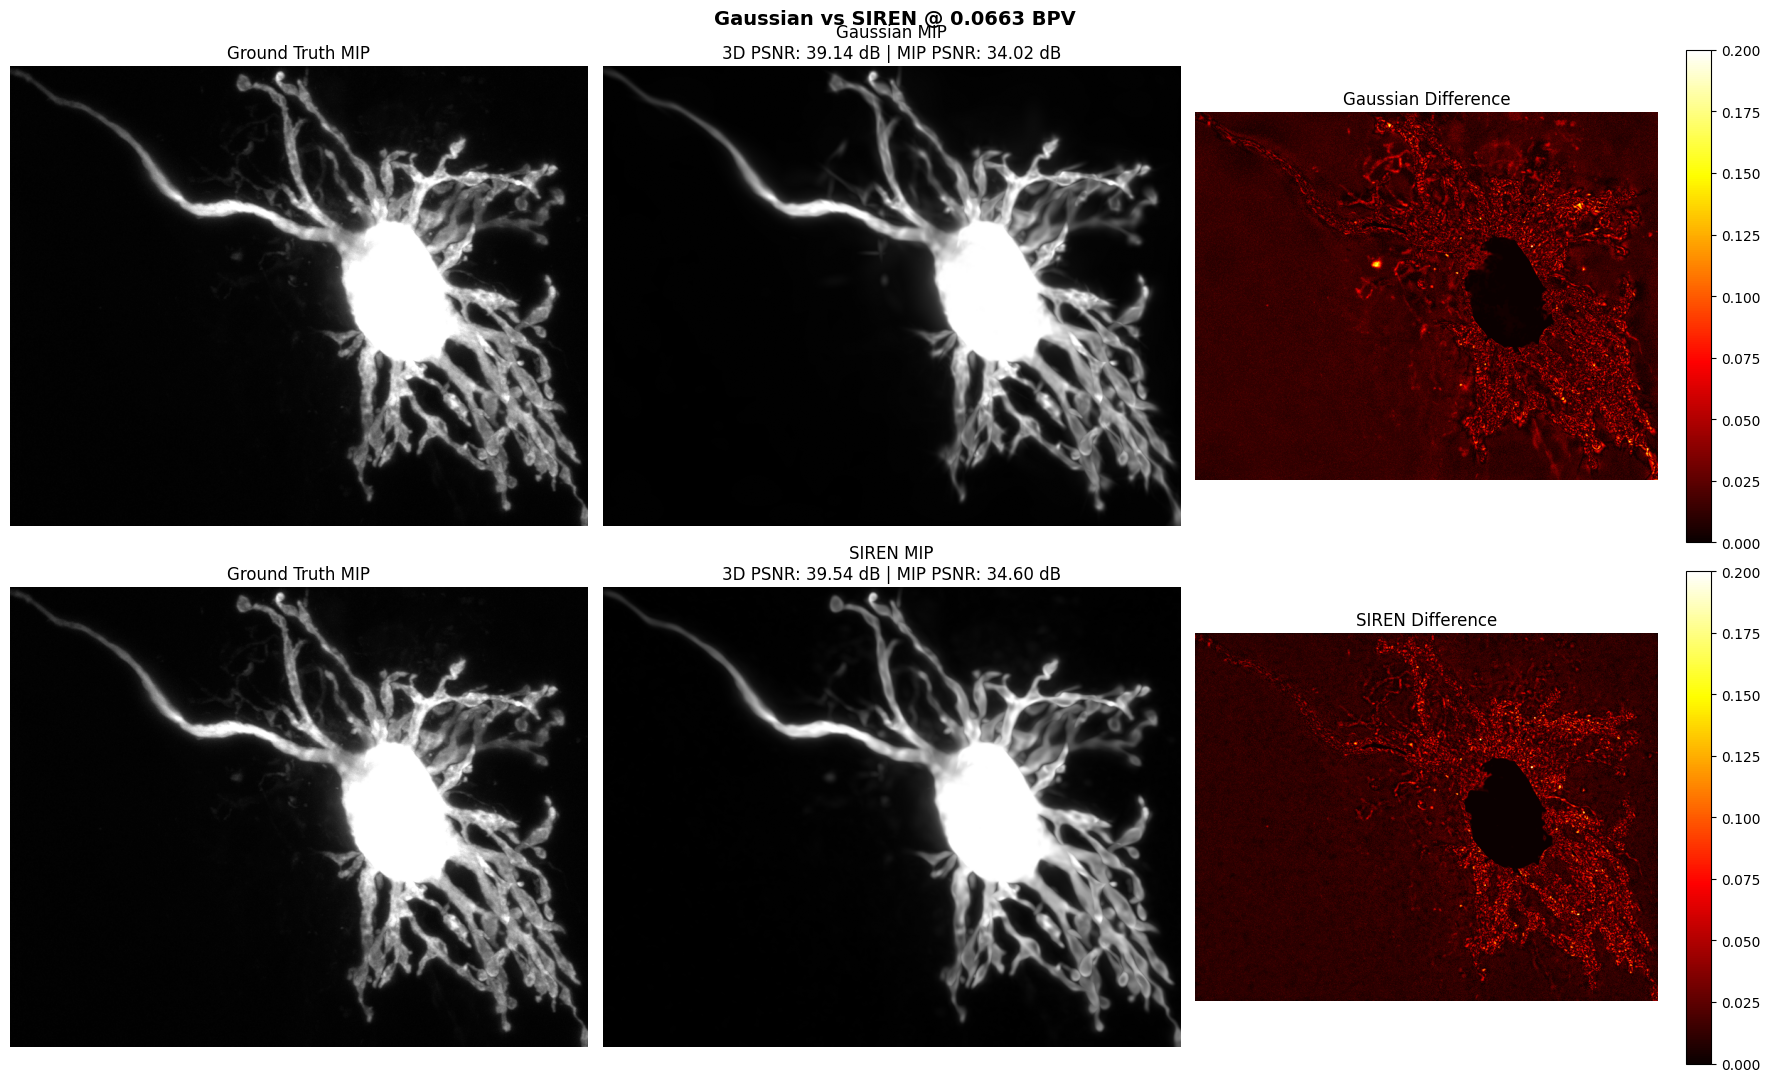

Comparison saved to gaussian_vs_siren.png


In [33]:
# ===================================================================
# Evaluate SIREN — reconstruct volume and compare with Gaussians
# ===================================================================

siren.eval()
siren_volume = np.zeros((Z, Y, X), dtype=np.float32)
chunk_size_eval = 4096

print("Reconstructing SIREN volume...")
with torch.no_grad():
    for iz_s in tqdm(range(Z), desc="SIREN slices"):
        yy_s, xx_s = torch.meshgrid(y_coords, x_coords, indexing='ij')
        zz_s = torch.full_like(yy_s, z_coords[iz_s])
        pts_s = torch.stack([xx_s.flatten(), yy_s.flatten(), zz_s.flatten()], dim=1)
        
        slice_vals = []
        for ci in range(0, pts_s.shape[0], chunk_size_eval):
            slice_vals.append(siren(pts_s[ci:ci+chunk_size_eval]).cpu())
        slice_vals = torch.cat(slice_vals, dim=0)
        siren_volume[iz_s] = slice_vals.reshape(Y, X).numpy()

siren_clipped = np.clip(siren_volume, 0.0, 1.0)

# --- 3D metrics ---
mse_siren = np.mean((gt_volume - siren_clipped) ** 2)
psnr_siren_3d = -10 * math.log10(max(mse_siren, 1e-12))

# --- MIP metrics ---
siren_mip = np.clip(np.max(siren_volume, axis=0), 0.0, 1.0)
psnr_siren_mip = psnr(gt_mip, siren_mip, data_range=1.0)
ssim_siren_mip = ssim(gt_mip, siren_mip, data_range=1.0)

print("\n" + "="*60)
print("SIREN vs GAUSSIAN — SAME BPV COMPARISON")
print("="*60)
print(f"{'Metric':<20} {'Gaussian':>12} {'SIREN':>12}")
print("-"*60)
print(f"{'BPV':<20} {bpv:>12.4f} {siren_bpv:>12.4f}")
print(f"{'Parameters':<20} {total_params:>12,} {siren_params:>12,}")
print(f"{'3D PSNR (dB)':<20} {psnr_3d:>12.2f} {psnr_siren_3d:>12.2f}")
print(f"{'MIP PSNR (dB)':<20} {psnr_value:>12.2f} {psnr_siren_mip:>12.2f}")
print(f"{'MIP SSIM':<20} {ssim_value:>12.4f} {ssim_siren_mip:>12.4f}")
print("="*60)

# --- Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

# Top row: Gaussian
axes[0, 0].imshow(gt_mip, cmap='gray')
axes[0, 0].set_title('Ground Truth MIP')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_mip_clipped, cmap='gray')
axes[0, 1].set_title(f'Gaussian MIP\n3D PSNR: {psnr_3d:.2f} dB | MIP PSNR: {psnr_value:.2f} dB')
axes[0, 1].axis('off')

g_diff = np.abs(gt_mip - recon_mip_clipped)
im0 = axes[0, 2].imshow(g_diff, cmap='hot', vmin=0, vmax=0.2)
axes[0, 2].set_title('Gaussian Difference')
axes[0, 2].axis('off')
plt.colorbar(im0, ax=axes[0, 2])

# Bottom row: SIREN
axes[1, 0].imshow(gt_mip, cmap='gray')
axes[1, 0].set_title('Ground Truth MIP')
axes[1, 0].axis('off')

axes[1, 1].imshow(siren_mip, cmap='gray')
axes[1, 1].set_title(f'SIREN MIP\n3D PSNR: {psnr_siren_3d:.2f} dB | MIP PSNR: {psnr_siren_mip:.2f} dB')
axes[1, 1].axis('off')

s_diff = np.abs(gt_mip - siren_mip)
im1 = axes[1, 2].imshow(s_diff, cmap='hot', vmin=0, vmax=0.2)
axes[1, 2].set_title('SIREN Difference')
axes[1, 2].axis('off')
plt.colorbar(im1, ax=axes[1, 2])

plt.suptitle(f'Gaussian vs SIREN @ {bpv:.4f} BPV', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gaussian_vs_siren.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison saved to gaussian_vs_siren.png")

In [36]:
# ===================================================================
# NeRF MLP Baseline — same BPV as Gaussian model for fair comparison
# ===================================================================
# Standard NeRF MLP: Linear(pe_dim→W) input, Linear(W→W) hidden,
# concat skip at midpoint → Linear(W+pe_dim, W), Linear(W→1) final.
# ===================================================================
import torch
import torch.nn as nn
import math

class NeRFMLP(nn.Module):
    """
    Standard NeRF-style MLP with positional encoding and concat skip.
    Architecture: PE → Linear(pe_dim,W) → [Linear(W,W)]×... → Linear(W,1)
    Concat skip connection at midpoint: Linear(W + pe_dim, W).
    """
    def __init__(self, in_features=3, out_features=1, hidden_features=128,
                 hidden_layers=4, num_freqs=6):
        super().__init__()
        self.num_freqs = num_freqs
        self.pe_dim = in_features * (2 * num_freqs + 1)
        self.skip_layer = hidden_layers // 2  # concat skip at this layer index

        # First layer: pe_dim → W
        self.input_layer = nn.Linear(self.pe_dim, hidden_features)

        # Hidden layers (W→W), except skip layer which is (W+pe_dim)→W
        self.hidden = nn.ModuleList()
        for i in range(1, hidden_layers):
            if i == self.skip_layer:
                self.hidden.append(nn.Linear(hidden_features + self.pe_dim, hidden_features))
            else:
                self.hidden.append(nn.Linear(hidden_features, hidden_features))

        self.final = nn.Linear(hidden_features, out_features)

        # Kaiming initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def positional_encoding(self, x):
        """Sinusoidal positional encoding: [x, sin(2^0 πx), cos(2^0 πx), ...]"""
        freqs = 2.0 ** torch.arange(self.num_freqs, device=x.device, dtype=x.dtype)
        x_freq = (x.unsqueeze(-1) * freqs).reshape(x.shape[0], -1)
        return torch.cat([x, torch.sin(x_freq), torch.cos(x_freq)], dim=-1)

    def forward(self, x):
        pe = self.positional_encoding(x)  # (B, pe_dim)
        h = torch.relu(self.input_layer(pe))
        for i, layer in enumerate(self.hidden):
            layer_idx = i + 1  # because input_layer is layer 0
            if layer_idx == self.skip_layer:
                h = torch.cat([h, pe], dim=-1)  # concat skip
            h = torch.relu(layer(h))
        return self.final(h).squeeze(-1)


# --- Find architecture matching target param count ---
# Param count with concat skip (S = L//2), L total hidden layers:
#   input_layer (pe_dim→W): pe_dim*W + W
#   (L-2) regular hidden layers (W→W): (L-2)*(W²+W)
#   1 skip layer (W+pe_dim→W): (W+pe_dim)*W + W
#   final (W→1): W+1
#   Total = (L-1)*W² + 2*pe_dim*W + (L+1)*W + 1
L_nerf = 4
best_config = None
best_diff = float('inf')

for F in range(4, 12):
    pe_dim = 3 * (2 * F + 1)
    for W in range(32, 300):
        p = (L_nerf - 1) * W * W + 2 * pe_dim * W + (L_nerf + 1) * W + 1
        diff = abs(p - target_params)
        if diff < best_diff:
            best_diff = diff
            best_config = (W, F, L_nerf, p, pe_dim)

W_nerf, F_nerf, L_nerf, p_nerf, pe_nerf = best_config

nerf = NeRFMLP(in_features=3, out_features=1, hidden_features=W_nerf,
               hidden_layers=L_nerf, num_freqs=F_nerf)
nerf_params = sum(p.numel() for p in nerf.parameters())
nerf_bpv = (nerf_params * 32) / num_voxels

print(f"NeRF MLP architecture: 3 → PE(F={F_nerf}, dim={pe_nerf}) → {W_nerf} → {W_nerf}×{W_nerf} × {L_nerf-1} (skip@{L_nerf//2}) → 1")
print(f"NeRF parameters:       {nerf_params:,}")
print(f"Target parameters:     {target_params:,}")
print(f"NeRF BPV:              {nerf_bpv:.4f} (target: {bpv:.4f})")
print(f"Param difference:      {nerf_params - target_params:+d}")

NeRF MLP architecture: 3 → PE(F=10, dim=63) → 170 → 170×170 × 3 (skip@2) → 1
NeRF parameters:       108,971
Target parameters:     108,977
NeRF BPV:              0.0663 (target: 0.0663)
Param difference:      -6


In [37]:
# ===================================================================
# Train NeRF MLP on the same volume
# ===================================================================
import os

nerf_ckpt_dir = 'checkpoints/nerf_mlp_sckpt'
os.makedirs(nerf_ckpt_dir, exist_ok=True)

nerf = nerf.cuda()
nerf.train()

optimizer_nerf = torch.optim.Adam(nerf.parameters(), lr=5e-4)
scheduler_nerf = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_nerf, T_max=100_000, eta_min=1e-6)

steps_nerf = 100_000
batch_size_nerf = 8192
best_loss_nerf = float('inf')

# Early stopping config
patience_nerf = 20
eval_interval_nerf = 500
best_psnr_nerf = -float('inf')
no_improve_nerf = 0

print(f"Training NeRF MLP for up to {steps_nerf} steps (early stopping: patience={patience_nerf} × {eval_interval_nerf} steps)")
print(f"Volume shape: {vol_gpu.shape}")
print(f"Checkpoints → {nerf_ckpt_dir}/")

pbar_nerf = tqdm(range(steps_nerf), desc="NeRF Training")
for step in pbar_nerf:
    idx = torch.randint(0, vol_gpu.numel(), (batch_size_nerf,), device='cuda')
    
    iz_n = idx // (Y_vol * X_vol)
    iy_n = (idx % (Y_vol * X_vol)) // X_vol
    ix_n = idx % X_vol
    
    xn = (ix_n.float() / max(X_vol - 1, 1)) * 2 - 1
    yn = (iy_n.float() / max(Y_vol - 1, 1)) * 2 - 1
    zn = (iz_n.float() / max(Z_vol - 1, 1)) * 2 - 1
    
    coords = torch.stack([xn, yn, zn], dim=1)
    gt_vals = vol_gpu[iz_n, iy_n, ix_n]
    
    pred = nerf(coords)
    loss = torch.nn.functional.mse_loss(pred, gt_vals)
    
    optimizer_nerf.zero_grad()
    loss.backward()
    optimizer_nerf.step()
    scheduler_nerf.step()
    
    if loss.item() < best_loss_nerf:
        best_loss_nerf = loss.item()
    
    if (step + 1) % eval_interval_nerf == 0:
        with torch.no_grad():
            eval_n = min(100_000, vol_gpu.numel())
            eval_idx = torch.randint(0, vol_gpu.numel(), (eval_n,), device='cuda')
            ez = eval_idx // (Y_vol * X_vol)
            ey = (eval_idx % (Y_vol * X_vol)) // X_vol
            ex = eval_idx % X_vol
            exn = (ex.float() / max(X_vol - 1, 1)) * 2 - 1
            eyn = (ey.float() / max(Y_vol - 1, 1)) * 2 - 1
            ezn = (ez.float() / max(Z_vol - 1, 1)) * 2 - 1
            eval_pts = torch.stack([exn, eyn, ezn], dim=1)
            eval_gt = vol_gpu[ez, ey, ex]
            eval_pred = []
            for ci in range(0, eval_n, 16384):
                eval_pred.append(nerf(eval_pts[ci:ci+16384]))
            eval_pred = torch.cat(eval_pred)
            mse_eval = torch.nn.functional.mse_loss(eval_pred, eval_gt).item()
            psnr_eval = -10 * math.log10(max(mse_eval, 1e-12))
        pbar_nerf.set_postfix({"loss": f"{loss.item():.6f}", "PSNR": f"{psnr_eval:.2f}", "best": f"{best_psnr_nerf:.2f}"})
        
        # Early stopping check
        if psnr_eval > best_psnr_nerf + 0.01:
            best_psnr_nerf = psnr_eval
            no_improve_nerf = 0
            torch.save(nerf.state_dict(), f'{nerf_ckpt_dir}/nerf_best.pt')
        else:
            no_improve_nerf += 1
        
        if no_improve_nerf >= patience_nerf:
            print(f"\nEarly stopping at step {step+1} (best PSNR: {best_psnr_nerf:.2f} dB)")
            break
    
    # Save checkpoint every 2000 steps
    if (step + 1) % 2000 == 0:
        torch.save(nerf.state_dict(), f'{nerf_ckpt_dir}/nerf_step{step+1}.pt')

# Load best checkpoint
nerf.load_state_dict(torch.load(f'{nerf_ckpt_dir}/nerf_best.pt'))
torch.save(nerf.state_dict(), f'{nerf_ckpt_dir}/nerf_final.pt')
print(f"\nNeRF training complete at step {step+1}. Best PSNR: {best_psnr_nerf:.2f} dB")
print(f"Checkpoints saved to {nerf_ckpt_dir}/")

Training NeRF MLP for up to 100000 steps (early stopping: patience=20 × 500 steps)
Volume shape: torch.Size([100, 647, 813])
Checkpoints → checkpoints/nerf_mlp_sckpt/


NeRF Training:   0%|          | 28/100000 [00:00<06:08, 271.43it/s]

NeRF Training: 100%|██████████| 100000/100000 [05:59<00:00, 278.32it/s, loss=0.000107, PSNR=39.35, best=39.48]


NeRF training complete at step 100000. Best PSNR: 39.48 dB
Checkpoints saved to checkpoints/nerf_mlp_sckpt/


Reconstructing NeRF volume...


NeRF slices: 100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


Reconstructing ReLU MLP volume...


ReLU slices: 100%|██████████| 100/100 [00:02<00:00, 36.29it/s]



GAUSSIAN vs SIREN vs NeRF MLP vs ReLU MLP — SAME BPV COMPARISON
Metric                     Gaussian          SIREN       NeRF MLP       ReLU MLP
--------------------------------------------------------------------------------------
BPV                          0.0663         0.0661         0.0663         0.0661
Parameters                  108,977        108,676        108,971        108,676
3D PSNR (dB)                  39.14          39.54          39.40          33.99
MIP PSNR (dB)                 34.02          34.60          34.09          25.76
MIP SSIM                     0.9458         0.9518         0.9476         0.8736


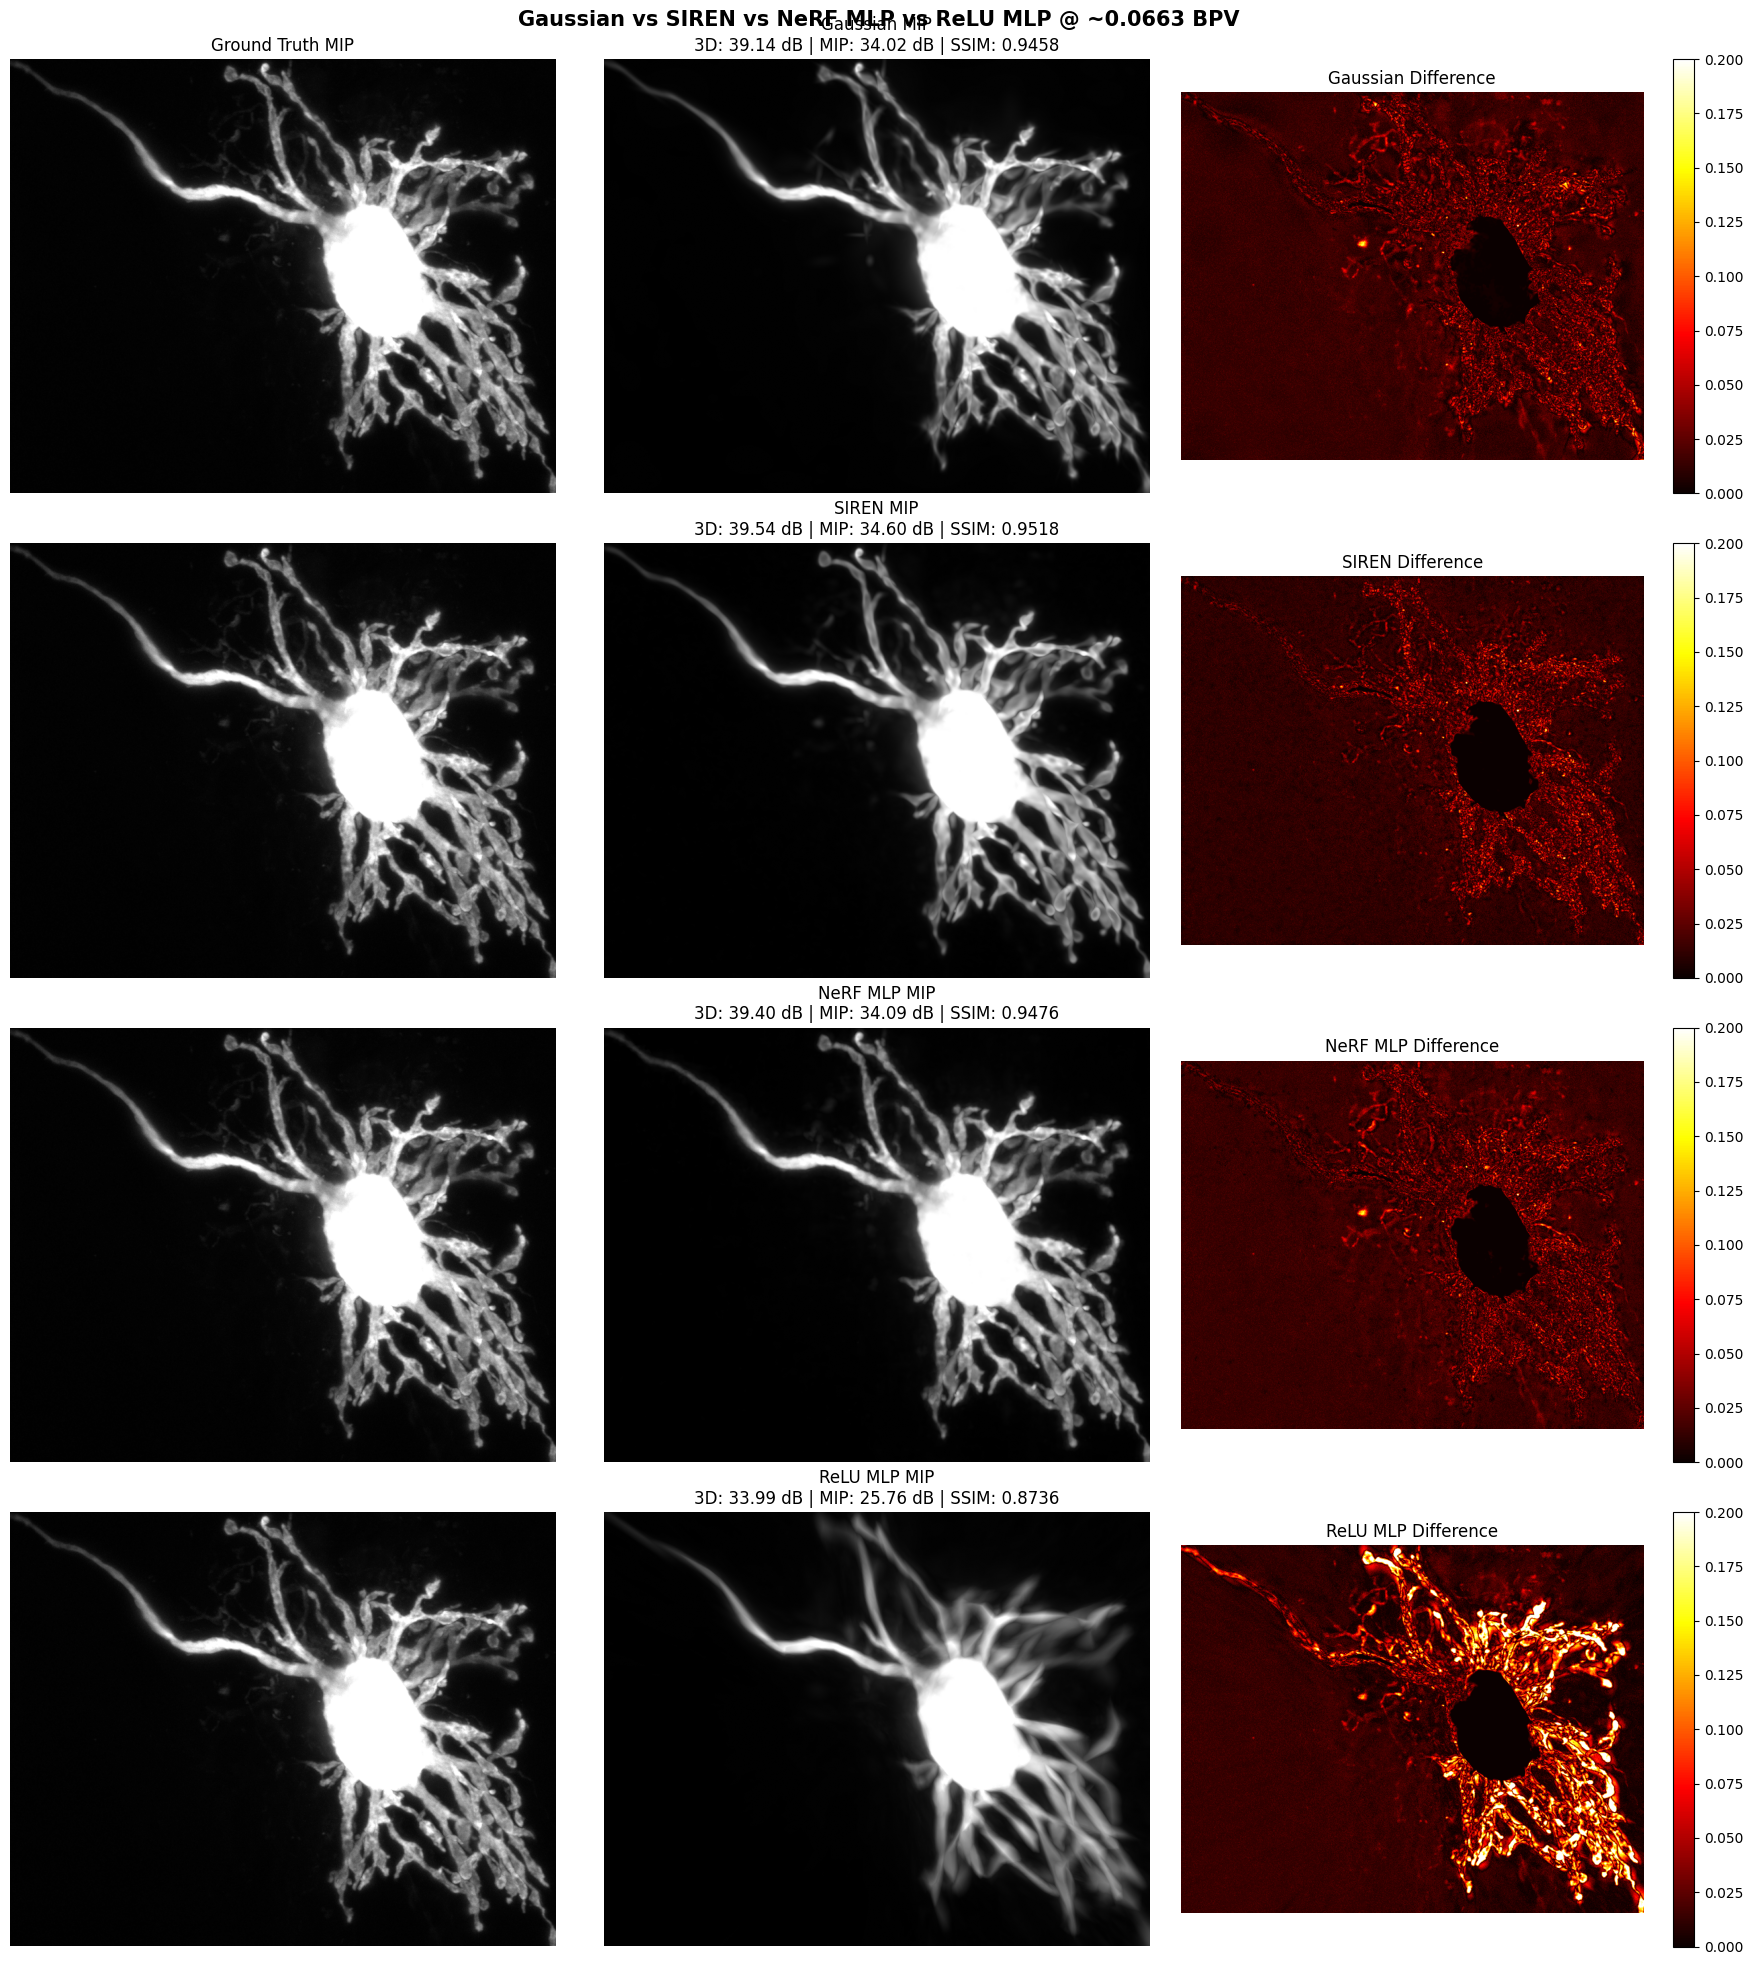

Comparison saved to four_way_comparison.png


In [ ]:
# ===================================================================
# Evaluate NeRF MLP — reconstruct volume and compare with Gaussians + SIREN
# ===================================================================

nerf.eval()
nerf_volume = np.zeros((Z, Y, X), dtype=np.float32)
chunk_size_eval = 4096

print("Reconstructing NeRF volume...")
with torch.no_grad():
    for iz_n in tqdm(range(Z), desc="NeRF slices"):
        yy_n, xx_n = torch.meshgrid(y_coords, x_coords, indexing='ij')
        zz_n = torch.full_like(yy_n, z_coords[iz_n])
        pts_n = torch.stack([xx_n.flatten(), yy_n.flatten(), zz_n.flatten()], dim=1)
        
        slice_vals = []
        for ci in range(0, pts_n.shape[0], chunk_size_eval):
            slice_vals.append(nerf(pts_n[ci:ci+chunk_size_eval]).cpu())
        slice_vals = torch.cat(slice_vals, dim=0)
        nerf_volume[iz_n] = slice_vals.reshape(Y, X).numpy()

nerf_clipped = np.clip(nerf_volume, 0.0, 1.0)

# --- 3D metrics ---
mse_nerf = np.mean((gt_volume - nerf_clipped) ** 2)
psnr_nerf_3d = -10 * math.log10(max(mse_nerf, 1e-12))

# --- MIP metrics ---
nerf_mip = np.clip(np.max(nerf_volume, axis=0), 0.0, 1.0)
psnr_nerf_mip = psnr(gt_mip, nerf_mip, data_range=1.0)
ssim_nerf_mip = ssim(gt_mip, nerf_mip, data_range=1.0)

print("\n" + "="*60)
print("NeRF MLP vs GAUSSIAN vs SIREN — SAME BPV COMPARISON")
print("="*60)
print(f"{'Metric':<20} {'Gaussian':>12} {'SIREN':>12} {'NeRF MLP':>12}")
print("-"*60)
print(f"{'BPV':<20} {bpv:>12.4f} {siren_bpv:>12.4f} {nerf_bpv:>12.4f}")
print(f"{'Parameters':<20} {total_params:>12,} {siren_params:>12,} {nerf_params:>12,}")
print(f"{'3D PSNR (dB)':<20} {psnr_3d:>12.2f} {psnr_siren_3d:>12.2f} {psnr_nerf_3d:>12.2f}")
print(f"{'MIP PSNR (dB)':<20} {psnr_value:>12.2f} {psnr_siren_mip:>12.2f} {psnr_nerf_mip:>12.2f}")
print(f"{'MIP SSIM':<20} {ssim_value:>12.4f} {ssim_siren_mip:>12.4f} {ssim_nerf_mip:>12.4f}")
print("="*60)

# --- Visualization ---
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

methods = [
    ("Gaussian", recon_mip_clipped, psnr_3d, psnr_value, ssim_value),
    ("SIREN", siren_mip, psnr_siren_3d, psnr_siren_mip, ssim_siren_mip),
    ("NeRF MLP", nerf_mip, psnr_nerf_3d, psnr_nerf_mip, ssim_nerf_mip),
]

for row, (name, mip, p3d, pmip, ss) in enumerate(methods):
    axes[row, 0].imshow(gt_mip, cmap='gray')
    axes[row, 0].set_title('Ground Truth MIP' if row == 0 else '')
    axes[row, 0].set_ylabel(name, fontsize=13, fontweight='bold')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(mip, cmap='gray')
    axes[row, 1].set_title(f'{name} MIP\n3D: {p3d:.2f} dB | MIP: {pmip:.2f} dB | SSIM: {ss:.4f}')
    axes[row, 1].axis('off')
    
    d = np.abs(gt_mip - mip)
    im = axes[row, 2].imshow(d, cmap='hot', vmin=0, vmax=0.2)
    axes[row, 2].set_title(f'{name} Difference')
    axes[row, 2].axis('off')
    plt.colorbar(im, ax=axes[row, 2])

plt.suptitle(f'Gaussian vs SIREN vs NeRF MLP @ ~{bpv:.4f} BPV', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('gaussian_vs_siren_vs_nerf.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison saved to gaussian_vs_siren_vs_nerf.png")

## INR (ReLU)

In [39]:
# ===================================================================
# Plain ReLU MLP Baseline — same BPV, no PE, no skip, no sine
# ===================================================================
# Standard MLP: Linear(3→W) input, Linear(W→W) hidden, Linear(W→1) final.
# ===================================================================
import torch
import torch.nn as nn
import math

class ReLUMLP(nn.Module):
    """
    Vanilla MLP with ReLU activations.
    No positional encoding, no skip connections.
    Architecture: 3→W → W→W × (L-1) → W→1.
    """
    def __init__(self, in_features=3, out_features=1, hidden_features=164,
                 hidden_layers=4):
        super().__init__()
        layers = []
        # First layer: in_features → W
        layers.append(nn.Linear(in_features, hidden_features))
        layers.append(nn.ReLU(inplace=True))
        # Hidden layers: W → W
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU(inplace=True))
        self.net = nn.Sequential(*layers)
        self.final = nn.Linear(hidden_features, out_features)

        # Kaiming init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.final(self.net(x)).squeeze(-1)


# --- Find width matching target param count ---
# Standard ReLU MLP param count (same formula as SIREN):
#   First layer (3→W): 3W + W = 4W
#   (L-1) hidden layers (W→W): (L-1)*(W²+W)
#   Final (W→1): W + 1
#   Total = (L-1)*W² + (L+3)*W + 1
L_relu = 4
a_r, b_r, c_r = L_relu - 1, L_relu + 3, 1 - target_params
W_relu = int((-b_r + math.sqrt(b_r**2 - 4 * a_r * c_r)) / (2 * a_r))

def count_relu_params(w, l=L_relu):
    return (l - 1) * w * w + (l + 3) * w + 1

best_W_r, best_diff_r = W_relu, abs(target_params - count_relu_params(W_relu))
for w in [W_relu - 2, W_relu - 1, W_relu, W_relu + 1, W_relu + 2]:
    if w < 1:
        continue
    if abs(count_relu_params(w) - target_params) < best_diff_r:
        best_W_r, best_diff_r = w, abs(count_relu_params(w) - target_params)
W_relu = best_W_r

relu_mlp = ReLUMLP(in_features=3, out_features=1, hidden_features=W_relu, hidden_layers=L_relu)
relu_params = sum(p.numel() for p in relu_mlp.parameters())
relu_bpv = (relu_params * 32) / num_voxels

print(f"ReLU MLP architecture: 3→{W_relu} → {W_relu}→{W_relu} × {L_relu-1} → {W_relu}→1")
print(f"ReLU MLP parameters:   {relu_params:,}")
print(f"Target parameters:     {target_params:,}")
print(f"ReLU MLP BPV:          {relu_bpv:.4f} (target: {bpv:.4f})")
print(f"Param difference:      {relu_params - target_params:+d}")

ReLU MLP architecture: 3→189 → 189→189 × 3 → 189→1
ReLU MLP parameters:   108,676
Target parameters:     108,977
ReLU MLP BPV:          0.0661 (target: 0.0663)
Param difference:      -301


In [40]:
# ===================================================================
# Train ReLU MLP on the same volume
# ===================================================================
import os

relu_ckpt_dir = 'checkpoints/relu_mlp_sckpt'
os.makedirs(relu_ckpt_dir, exist_ok=True)

relu_mlp = relu_mlp.cuda()
relu_mlp.train()

optimizer_relu = torch.optim.Adam(relu_mlp.parameters(), lr=5e-4)
scheduler_relu = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_relu, T_max=100_000, eta_min=1e-6)

steps_relu = 100_000
batch_size_relu = 8192
best_loss_relu = float('inf')

# Early stopping config
patience_relu = 20
eval_interval_relu = 500
best_psnr_relu = -float('inf')
no_improve_relu = 0

print(f"Training ReLU MLP for up to {steps_relu} steps (early stopping: patience={patience_relu} × {eval_interval_relu} steps)")
print(f"Checkpoints → {relu_ckpt_dir}/")

pbar_relu = tqdm(range(steps_relu), desc="ReLU MLP Training")
for step in pbar_relu:
    idx = torch.randint(0, vol_gpu.numel(), (batch_size_relu,), device='cuda')
    
    iz_r = idx // (Y_vol * X_vol)
    iy_r = (idx % (Y_vol * X_vol)) // X_vol
    ix_r = idx % X_vol
    
    xn = (ix_r.float() / max(X_vol - 1, 1)) * 2 - 1
    yn = (iy_r.float() / max(Y_vol - 1, 1)) * 2 - 1
    zn = (iz_r.float() / max(Z_vol - 1, 1)) * 2 - 1
    
    coords = torch.stack([xn, yn, zn], dim=1)
    gt_vals = vol_gpu[iz_r, iy_r, ix_r]
    
    pred = relu_mlp(coords)
    loss = torch.nn.functional.mse_loss(pred, gt_vals)
    
    optimizer_relu.zero_grad()
    loss.backward()
    optimizer_relu.step()
    scheduler_relu.step()
    
    if loss.item() < best_loss_relu:
        best_loss_relu = loss.item()
    
    if (step + 1) % eval_interval_relu == 0:
        with torch.no_grad():
            eval_n = min(100_000, vol_gpu.numel())
            eval_idx = torch.randint(0, vol_gpu.numel(), (eval_n,), device='cuda')
            ez = eval_idx // (Y_vol * X_vol)
            ey = (eval_idx % (Y_vol * X_vol)) // X_vol
            ex = eval_idx % X_vol
            exn = (ex.float() / max(X_vol - 1, 1)) * 2 - 1
            eyn = (ey.float() / max(Y_vol - 1, 1)) * 2 - 1
            ezn = (ez.float() / max(Z_vol - 1, 1)) * 2 - 1
            eval_pts = torch.stack([exn, eyn, ezn], dim=1)
            eval_gt = vol_gpu[ez, ey, ex]
            eval_pred = []
            for ci in range(0, eval_n, 16384):
                eval_pred.append(relu_mlp(eval_pts[ci:ci+16384]))
            eval_pred = torch.cat(eval_pred)
            mse_eval = torch.nn.functional.mse_loss(eval_pred, eval_gt).item()
            psnr_eval = -10 * math.log10(max(mse_eval, 1e-12))
        pbar_relu.set_postfix({"loss": f"{loss.item():.6f}", "PSNR": f"{psnr_eval:.2f}", "best": f"{best_psnr_relu:.2f}"})
        
        # Early stopping check
        if psnr_eval > best_psnr_relu + 0.01:
            best_psnr_relu = psnr_eval
            no_improve_relu = 0
            torch.save(relu_mlp.state_dict(), f'{relu_ckpt_dir}/relu_best.pt')
        else:
            no_improve_relu += 1
        
        if no_improve_relu >= patience_relu:
            print(f"\nEarly stopping at step {step+1} (best PSNR: {best_psnr_relu:.2f} dB)")
            break
    
    # Save checkpoint every 2000 steps
    if (step + 1) % 2000 == 0:
        torch.save(relu_mlp.state_dict(), f'{relu_ckpt_dir}/relu_step{step+1}.pt')

# Load best checkpoint
relu_mlp.load_state_dict(torch.load(f'{relu_ckpt_dir}/relu_best.pt'))
torch.save(relu_mlp.state_dict(), f'{relu_ckpt_dir}/relu_final.pt')
print(f"\nReLU MLP training complete at step {step+1}. Best PSNR: {best_psnr_relu:.2f} dB")
print(f"Checkpoints saved to {relu_ckpt_dir}/")

Training ReLU MLP for up to 100000 steps (early stopping: patience=20 × 500 steps)
Checkpoints → checkpoints/relu_mlp_sckpt/


ReLU MLP Training:   0%|          | 0/100000 [00:00<?, ?it/s]

ReLU MLP Training:  98%|█████████▊| 97999/100000 [05:27<00:06, 298.96it/s, loss=0.000397, PSNR=34.12, best=34.16]


Early stopping at step 98000 (best PSNR: 34.16 dB)

ReLU MLP training complete at step 98000. Best PSNR: 34.16 dB
Checkpoints saved to checkpoints/relu_mlp_sckpt/


In [ ]:
# ===================================================================
# Evaluate ReLU MLP — reconstruct volume and compare with all models
# ===================================================================

relu_mlp.eval()
relu_volume = np.zeros((Z, Y, X), dtype=np.float32)
chunk_size_eval = 4096

print("Reconstructing ReLU MLP volume...")
with torch.no_grad():
    for iz_r in tqdm(range(Z), desc="ReLU slices"):
        yy_r, xx_r = torch.meshgrid(y_coords, x_coords, indexing='ij')
        zz_r = torch.full_like(yy_r, z_coords[iz_r])
        pts_r = torch.stack([xx_r.flatten(), yy_r.flatten(), zz_r.flatten()], dim=1)
        
        slice_vals = []
        for ci in range(0, pts_r.shape[0], chunk_size_eval):
            slice_vals.append(relu_mlp(pts_r[ci:ci+chunk_size_eval]).cpu())
        slice_vals = torch.cat(slice_vals, dim=0)
        relu_volume[iz_r] = slice_vals.reshape(Y, X).numpy()

relu_clipped = np.clip(relu_volume, 0.0, 1.0)

# --- 3D metrics ---
mse_relu = np.mean((gt_volume - relu_clipped) ** 2)
psnr_relu_3d = -10 * math.log10(max(mse_relu, 1e-12))

# --- MIP metrics ---
relu_mip = np.clip(np.max(relu_volume, axis=0), 0.0, 1.0)
psnr_relu_mip = psnr(gt_mip, relu_mip, data_range=1.0)
ssim_relu_mip = ssim(gt_mip, relu_mip, data_range=1.0)

print("\n" + "="*86)
print("GAUSSIAN vs SIREN vs NeRF MLP vs ReLU MLP — SAME BPV COMPARISON")
print("="*86)
print(f"{'Metric':<20} {'Gaussian':>14} {'SIREN':>14} {'NeRF MLP':>14} {'ReLU MLP':>14}")
print("-"*86)
print(f"{'BPV':<20} {bpv:>14.4f} {siren_bpv:>14.4f} {nerf_bpv:>14.4f} {relu_bpv:>14.4f}")
print(f"{'Parameters':<20} {total_params:>14,} {siren_params:>14,} {nerf_params:>14,} {relu_params:>14,}")
print(f"{'3D PSNR (dB)':<20} {psnr_3d:>14.2f} {psnr_siren_3d:>14.2f} {psnr_nerf_3d:>14.2f} {psnr_relu_3d:>14.2f}")
print(f"{'MIP PSNR (dB)':<20} {psnr_value:>14.2f} {psnr_siren_mip:>14.2f} {psnr_nerf_mip:>14.2f} {psnr_relu_mip:>14.2f}")
print(f"{'MIP SSIM':<20} {ssim_value:>14.4f} {ssim_siren_mip:>14.4f} {ssim_nerf_mip:>14.4f} {ssim_relu_mip:>14.4f}")
print("="*86)

# --- Visualization ---
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

methods = [
    ("Gaussian", recon_mip_clipped, psnr_3d, psnr_value, ssim_value),
    ("SIREN", siren_mip, psnr_siren_3d, psnr_siren_mip, ssim_siren_mip),
    ("NeRF MLP", nerf_mip, psnr_nerf_3d, psnr_nerf_mip, ssim_nerf_mip),
    ("ReLU MLP", relu_mip, psnr_relu_3d, psnr_relu_mip, ssim_relu_mip),
]

for row, (name, mip_img, p3d, pmip, ss) in enumerate(methods):
    axes[row, 0].imshow(gt_mip, cmap='gray')
    axes[row, 0].set_title('Ground Truth MIP' if row == 0 else '')
    axes[row, 0].set_ylabel(name, fontsize=13, fontweight='bold')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(mip_img, cmap='gray')
    axes[row, 1].set_title(f'{name} MIP\n3D: {p3d:.2f} dB | MIP: {pmip:.2f} dB | SSIM: {ss:.4f}')
    axes[row, 1].axis('off')
    
    d = np.abs(gt_mip - mip_img)
    im = axes[row, 2].imshow(d, cmap='hot', vmin=0, vmax=0.2)
    axes[row, 2].set_title(f'{name} Difference')
    axes[row, 2].axis('off')
    plt.colorbar(im, ax=axes[row, 2])

plt.suptitle(f'Gaussian vs SIREN vs NeRF MLP vs ReLU MLP @ ~{bpv:.4f} BPV', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('four_way_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison saved to four_way_comparison.png")

SUMMARY — ALL MODELS @ MATCHED PARAMETER BUDGET
          3D PSNR (dB)  MIP PSNR (dB)  MIP SSIM     BPV Compression
Model                                                              
Gaussian         39.14          34.02    0.9458  0.0663      482.7x
SIREN            39.54          34.60    0.9518  0.0661      484.0x
NeRF MLP         39.40          34.09    0.9476  0.0663      482.7x
ReLU MLP         33.99          25.76    0.8736  0.0661      484.0x


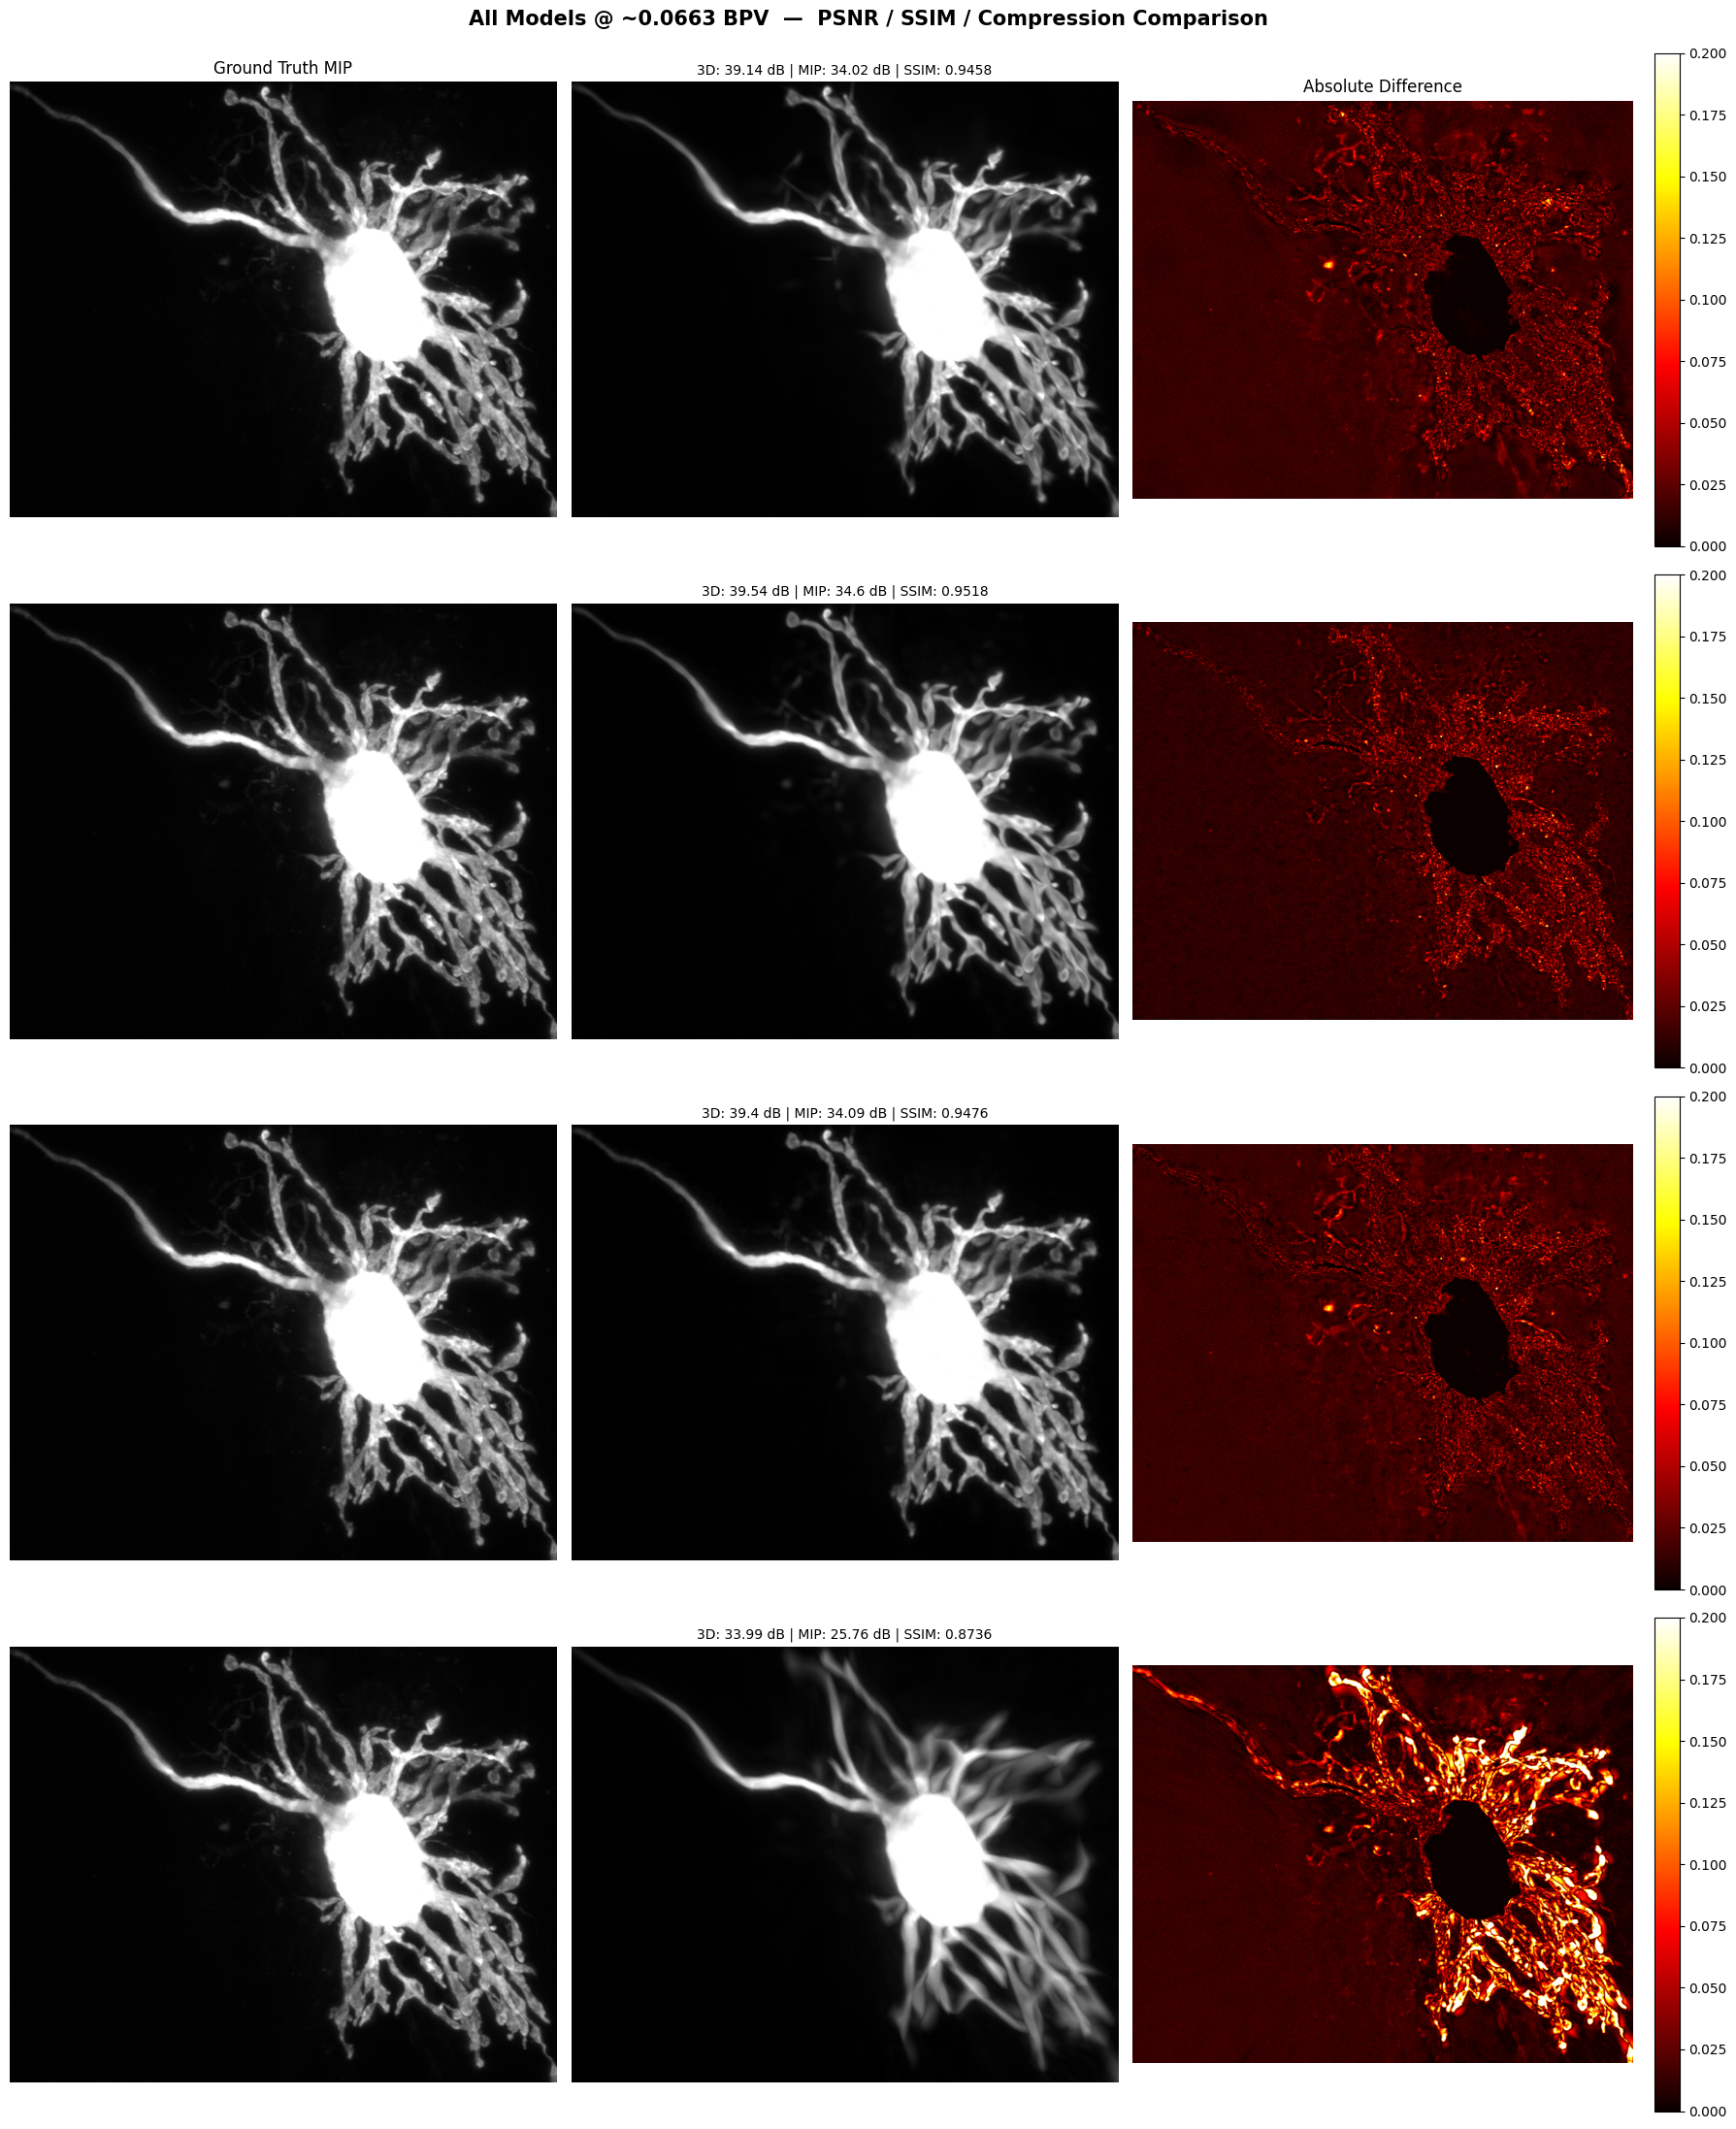

Saved to all_models_comparison.png


In [43]:
# ===================================================================
# Summary Table + Visualization: All Models
# ===================================================================
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# --- Compute all metrics from reconstructed volumes ---
models = [
    ('Gaussian', reconstructed_volume, total_params),
    ('SIREN',    siren_volume,         siren_params),
    ('NeRF MLP', nerf_volume,          nerf_params),
    ('ReLU MLP', relu_volume,          relu_params),
]

rows = []
mips = {}
for name, vol, n_params in models:
    clipped = np.clip(vol, 0.0, 1.0)
    mse_val = np.mean((gt_volume - clipped) ** 2)
    psnr_3d_val = -10 * math.log10(max(mse_val, 1e-12))
    mip_img = np.clip(np.max(vol, axis=0), 0.0, 1.0)
    psnr_mip_val = psnr(gt_mip, mip_img, data_range=1.0)
    ssim_mip_val = ssim(gt_mip, mip_img, data_range=1.0)
    bpv_val = (n_params * 32) / num_voxels
    cr_val = num_voxels / n_params

    mips[name] = mip_img
    rows.append({
        'Model': name,
        '3D PSNR (dB)': round(psnr_3d_val, 2),
        'MIP PSNR (dB)': round(psnr_mip_val, 2),
        'MIP SSIM': round(ssim_mip_val, 4),
        'BPV': round(bpv_val, 4),
        'Compression': f'{cr_val:.1f}x',
    })

df = pd.DataFrame(rows).set_index('Model')
print("=" * 80)
print("SUMMARY — ALL MODELS @ MATCHED PARAMETER BUDGET")
print("=" * 80)
print(df.to_string())
print("=" * 80)

# --- 4-row visualization: GT | Reconstruction | Difference ---
fig, axes = plt.subplots(4, 3, figsize=(18, 22))

for row_idx, (name, vol, n_params) in enumerate(models):
    mip_img = mips[name]
    r = rows[row_idx]

    # Column 0: Ground Truth
    axes[row_idx, 0].imshow(gt_mip, cmap='gray')
    axes[row_idx, 0].set_ylabel(name, fontsize=14, fontweight='bold')
    if row_idx == 0:
        axes[row_idx, 0].set_title('Ground Truth MIP', fontsize=12)
    axes[row_idx, 0].axis('off')

    # Column 1: Reconstructed MIP
    axes[row_idx, 1].imshow(mip_img, cmap='gray')
    axes[row_idx, 1].set_title(
        f"3D: {r['3D PSNR (dB)']} dB | MIP: {r['MIP PSNR (dB)']} dB | SSIM: {r['MIP SSIM']}",
        fontsize=10)
    axes[row_idx, 1].axis('off')

    # Column 2: Difference map
    diff = np.abs(gt_mip - mip_img)
    im = axes[row_idx, 2].imshow(diff, cmap='hot', vmin=0, vmax=0.2)
    if row_idx == 0:
        axes[row_idx, 2].set_title('Absolute Difference', fontsize=12)
    axes[row_idx, 2].axis('off')
    plt.colorbar(im, ax=axes[row_idx, 2], fraction=0.046, pad=0.04)

plt.suptitle(
    f'All Models @ ~{bpv:.4f} BPV  —  PSNR / SSIM / Compression Comparison',
    fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved to all_models_comparison.png")